In [12]:
from collections import defaultdict
import os

import matplotlib.pyplot as plt
import scipy.stats

from jax import pure_callback, random
import jax.numpy as jnp
import optax

import numpyro
from numpyro import handlers
from numpyro.contrib.funsor import config_enumerate, infer_discrete
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import SVI, TraceEnum_ELBO, init_to_value
from numpyro.infer.autoguide import AutoDelta

%matplotlib inline

smoke_test = "CI" in os.environ
assert numpyro.__version__.startswith("0.13.2")

In [13]:
data = jnp.array([0.0, 1.0, 10.0, 11.0, 12.0])
len(data)

5

In [27]:
K = 2  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables
    weights = numpyro.sample("weights", dist.Dirichlet(0.5 * jnp.ones(K)))
    scale = numpyro.sample("scale", dist.LogNormal(0.0, 2.0))
    with numpyro.plate("components", K):
        locs = numpyro.sample("locs", dist.Normal(0.0, 10.0))

    with numpyro.plate("data", len(data)):
        # Local variables
        assignment = numpyro.sample("assignment", dist.Categorical(weights))
        print(assignment.shape)
        print(locs[assignment].shape)
        numpyro.sample("obs", dist.Normal(locs[assignment], scale), obs=data)


(5,)
(5,)
(5,)
(5,)


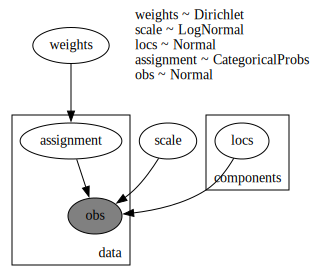

In [28]:
# render model
numpyro.render_model(model, model_args=(data,) ,render_distributions=True)


In [29]:
elbo = TraceEnum_ELBO()

def initialize(seed):
    global global_guide
    init_values = {
        "weights": jnp.ones(K) / K,
        "scale": jnp.sqrt(data.var() / 2),
        "locs": data[
            random.categorical(
                random.PRNGKey(seed), jnp.ones(len(data)) / len(data), shape=(K,)
            )
        ],
    }
    global_model = handlers.block(
        handlers.seed(model, random.PRNGKey(0)),
        hide_fn=lambda site: site["name"]
        not in ["weights", "scale", "locs", "components"],
    )
    global_guide = AutoDelta(
        global_model, init_loc_fn=init_to_value(values=init_values)
    )
    handlers.seed(global_guide, random.PRNGKey(0))(data)  # warm up the guide
    return elbo.loss(random.PRNGKey(0), {}, model, global_guide, data)


# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)  # initialize the global_guide
print(f"seed = {seed}, initial_loss = {loss}")

(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)
(5,)
(5,)
(5,)
(5,

In [30]:
# Helper function to collect gradient norms during training
def hook_optax(optimizer):
    gradient_norms = defaultdict(list)

    def append_grad(grad):
        for name, g in grad.items():
            gradient_norms[name].append(float(jnp.linalg.norm(g)))
        return grad

    def update_fn(grads, state, params=None):
        grads = pure_callback(append_grad, grads, grads)
        return optimizer.update(grads, state, params=params)

    return optax.GradientTransformation(optimizer.init, update_fn), gradient_norms


optim, gradient_norms = hook_optax(optax.adam(learning_rate=0.1, b1=0.8, b2=0.99))
global_svi = SVI(model, global_guide, optim, loss=elbo)


In [31]:
global_svi_result = global_svi.run(
    random.PRNGKey(0), 200 if not smoke_test else 2, data
)

(5,)
(5,)


  0%|          | 0/200 [00:00<?, ?it/s]

(5,)
(5,)
(5,)
(5,)
(2, 1)
(2, 1)


100%|██████████| 200/200 [00:00<00:00, 635.05it/s, init loss: 25.1498, avg. loss [191-200]: 17.4433]


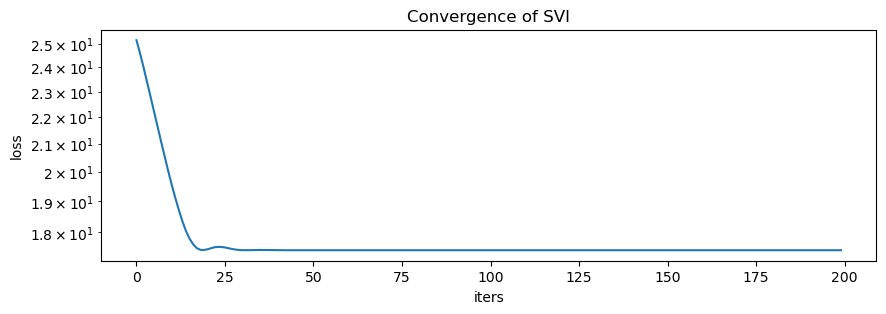

In [32]:
plt.figure(figsize=(10, 3), dpi=100).set_facecolor("white")
plt.plot(global_svi_result.losses)
plt.xlabel("iters")
plt.ylabel("loss")
plt.yscale("log")
plt.title("Convergence of SVI")
plt.show()

In [33]:
map_estimates = global_svi_result.params
weights = map_estimates["weights_auto_loc"]
locs = map_estimates["locs_auto_loc"]
scale = map_estimates["scale_auto_loc"]
print(f"weights = {weights}")
print(f"locs = {locs}")
print(f"scale = {scale}")

weights = [0.375 0.625]
locs = [ 0.49895036 10.984347  ]
scale = 0.6514335870742798


In [34]:
map_estimates.keys()

dict_keys(['locs_auto_loc', 'scale_auto_loc', 'weights_auto_loc'])

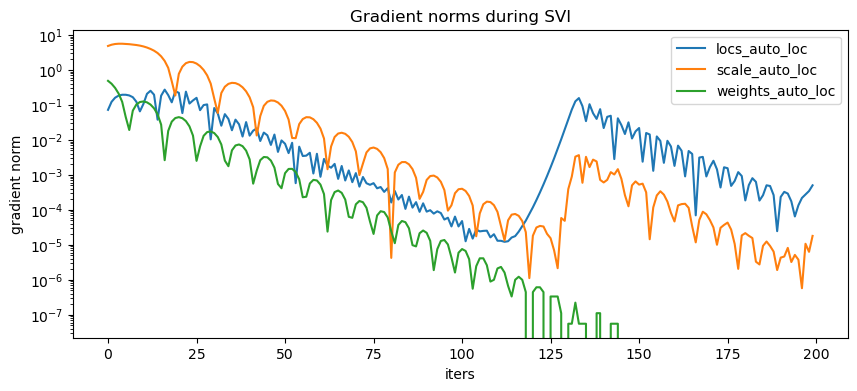

In [35]:
plt.figure(figsize=(10, 4), dpi=100).set_facecolor("white")
for name, grad_norms in gradient_norms.items():
    plt.plot(grad_norms, label=name)
plt.xlabel("iters")
plt.ylabel("gradient norm")
plt.yscale("log")
plt.legend(loc="best")
plt.title("Gradient norms during SVI")
plt.show()

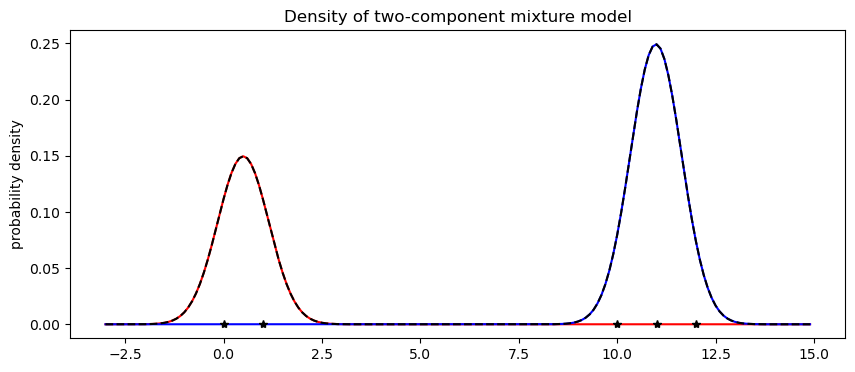

In [36]:
X = jnp.arange(-3, 15, 0.1)
Y1 = weights[0] * scipy.stats.norm.pdf((X - locs[0]) / scale)
Y2 = weights[1] * scipy.stats.norm.pdf((X - locs[1]) / scale)

plt.figure(figsize=(10, 4), dpi=100).set_facecolor("white")
plt.plot(X, Y1, "r-")
plt.plot(X, Y2, "b-")
plt.plot(X, Y1 + Y2, "k--")
plt.plot(data, jnp.zeros(len(data)), "k*")
plt.title("Density of two-component mixture model")
plt.ylabel("probability density")
plt.show()